## Visualising electron density
Load a saved model, sample to get locations and get a plot for the electron densities

In [1]:
from nn_helium.nn import model, psi_nn

In [2]:
import torch
import numpy as np

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
checkpoint = torch.load("nn_helium/model_500ep.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
from nn_helium.cluster_nn import metropolis, get_local_energy, get_variances

mc_steps = 50
n_walkers = 4096
keep_mc_steps = False
device = torch.device("cuda")
cpu = torch.device("cpu")

In [6]:
pos = torch.rand((n_walkers, 6))
for epoch in range(10):

    with torch.no_grad():
        pos = metropolis(
            mc_steps, pos, n_walkers, model.to(cpu), keep_mc_steps=keep_mc_steps)

    E = get_local_energy(
        pos.to(device), model.to(device))
    
    variance = get_variances(E)
    mean_energy = torch.mean(E)

In [27]:
n_walkers = 10000
pos = torch.rand((n_walkers, 6))
pos = metropolis(
            mc_steps, pos, n_walkers, model.to(cpu), keep_mc_steps=keep_mc_steps)
pos = pos.to(cpu)

In [8]:
prob_density = psi_nn(pos, model).detach().to(cpu)

In [9]:
prob_density

tensor([0.0077, 0.0193, 0.0090,  ..., 0.0016, 0.0047, 0.0014])

In [20]:
x = pos[:, 3]
y = pos[:, 4]

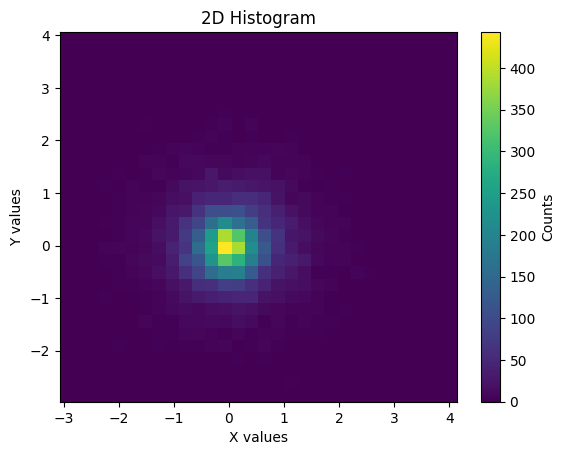

In [23]:
import matplotlib.pyplot as plt
import numpy as np


# Create 2D histogram
plt.hist2d(x, y, bins=30, cmap='plasma')
plt.hist2d(pos[:, 0], pos[:, 1], bins=30, cmap='viridis')

# Add colorbar to show counts
plt.colorbar(label='Counts')

plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('2D Histogram')
plt.show()


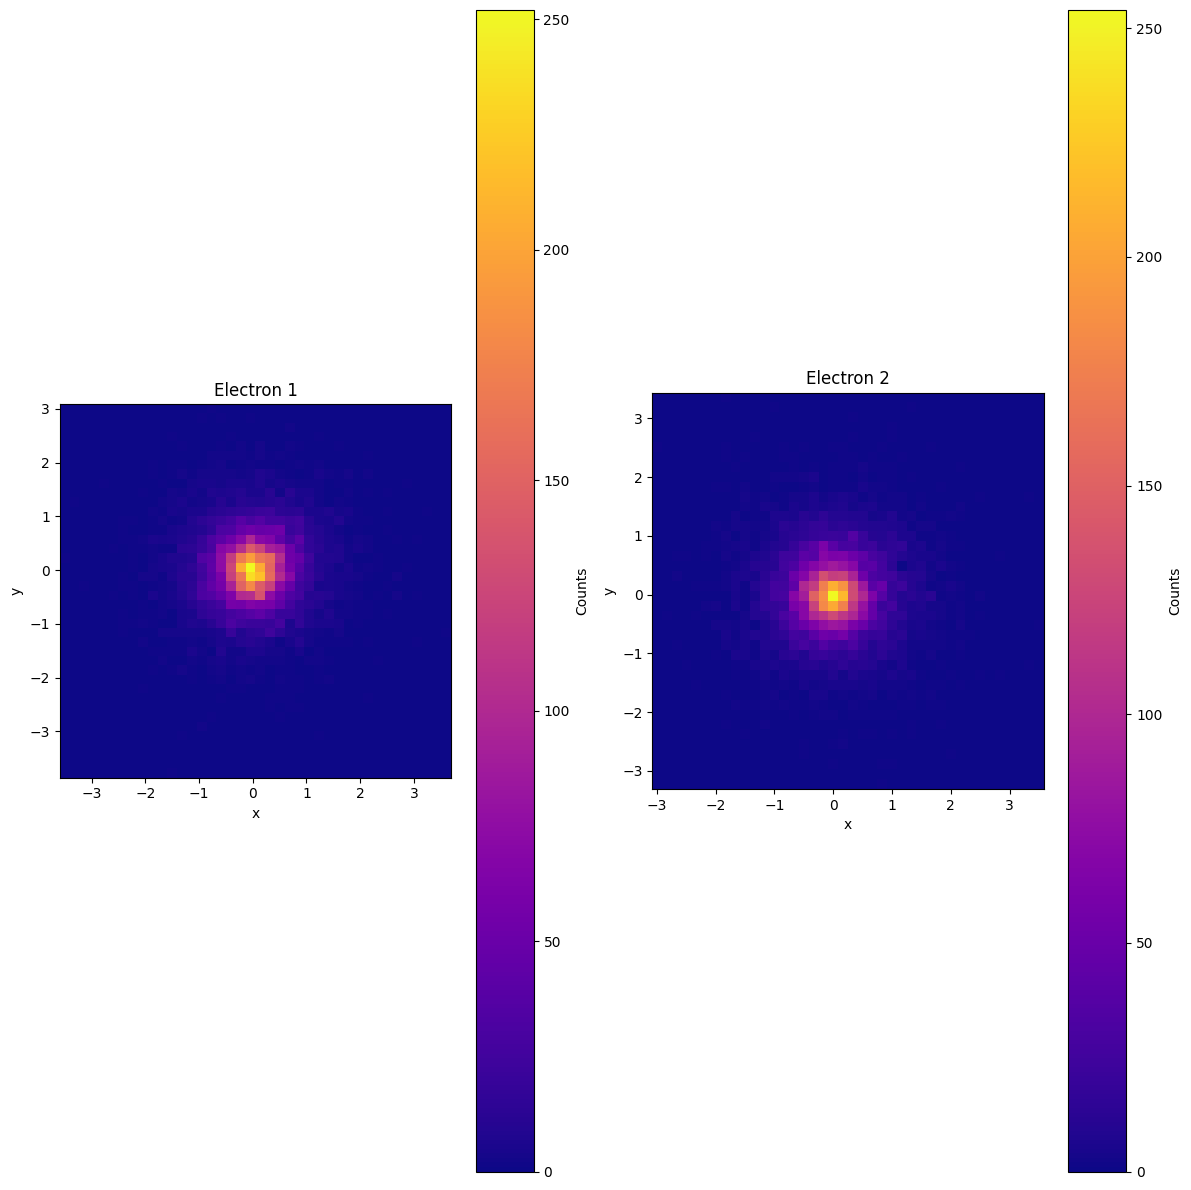

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_electron_histograms(pos, bins=50, max_cols=3, figsize=(12, 12)):
    """
    Plot 2D histograms of electron positions from QMC simulation.
    Each electron gets its own subplot, arranged in a grid with square axes.
    
    Parameters
    ----------
    pos : np.ndarray
        Shape (batch_size, n_electrons*3).
        Coordinates stored as (x, y, z) for each electron.
    bins : int
        Number of histogram bins per axis.
    max_cols : int
        Maximum number of columns in the subplot grid.
    figsize : tuple
        Size of the matplotlib figure.
    """
    batch_size, total_dim = pos.shape
    n_electrons = total_dim // 3

    ncols = min(n_electrons, max_cols)
    nrows = math.ceil(n_electrons / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = np.array(axes).reshape(-1)  # flatten in case of 2D array

    for i in range(n_electrons):
        ax = axes[i]
        # extract x,y for electron i
        x = pos[:, 3*i]
        y = pos[:, 3*i + 1]
        
        h = ax.hist2d(x, y, bins=bins, cmap="plasma")
        fig.colorbar(h[3], ax=ax, label="Counts")
        
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"Electron {i+1}")
        ax.set_aspect("equal")  # make plots square

    # Hide any unused axes
    for j in range(n_electrons, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Example usage
plot_electron_histograms(pos, bins=40, max_cols=3)


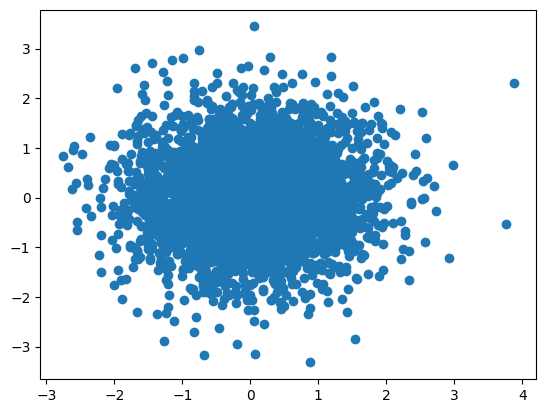

In [13]:
import matplotlib.pyplot as plt

plt.scatter(x, y)

In [15]:
x.shape

torch.Size([10000])

In [14]:
t = np.histogramdd(np.array([x, y]))

ValueError: maximum supported dimension for an ndarray is currently 64, found 10000

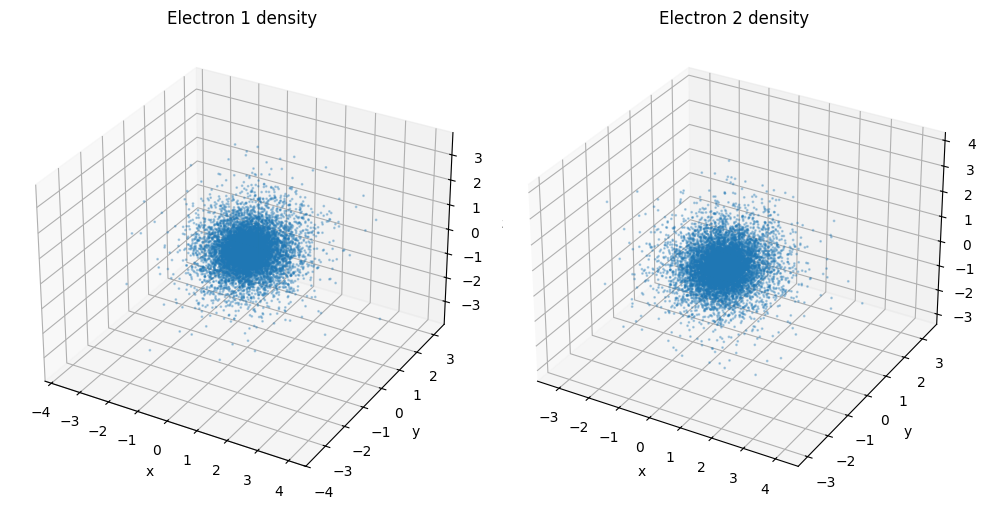

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers 3D projection

# Suppose `samples` has shape (batch_size, 3 * n_elec)
# Each row: [x1, y1, z1, x2, y2, z2, ...]
batch_size, dim = samples.shape
n_elec = dim // 3

fig = plt.figure(figsize=(5 * n_elec, 5))

for i in range(n_elec):
    ax = fig.plot(1, n_elec, i + 1, projection='3d')
    
    # extract coordinates of electron i
    coords = samples[:, 3*i:3*i+3]
    x, y, z = coords.T
    
    # scatter plot of positions
    ax.scatter(x, y, z, s=1, alpha=0.3)
    ax.set_title(f"Electron {i+1} density")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

plt.tight_layout()
plt.show()


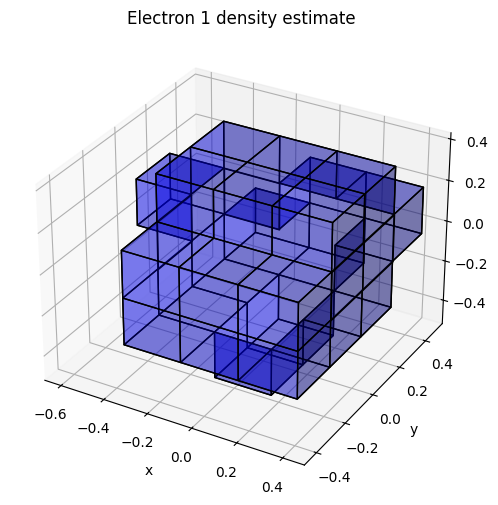

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Example electron
elec_idx = 0
coords = samples[:, 3*elec_idx:3*elec_idx+3]

# Histogram
bins = 30
hist, edges = np.histogramdd(coords, bins=bins, density=True)

# Build voxel grid coordinates (need edges, not centers)
xedges, yedges, zedges = edges
X, Y, Z = np.meshgrid(xedges, yedges, zedges, indexing='ij')

# Define mask: which voxels to fill
threshold = hist.max() * 0.3
mask = hist > threshold

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Note: ax.voxels expects mask.shape = (nx, ny, nz)
# and coordinate arrays shape = (nx+1, ny+1, nz+1)
ax.voxels(X, Y, Z, mask, facecolors='blue', edgecolor='k', alpha=0.3)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(f'Electron {elec_idx+1} density estimate')

plt.show()


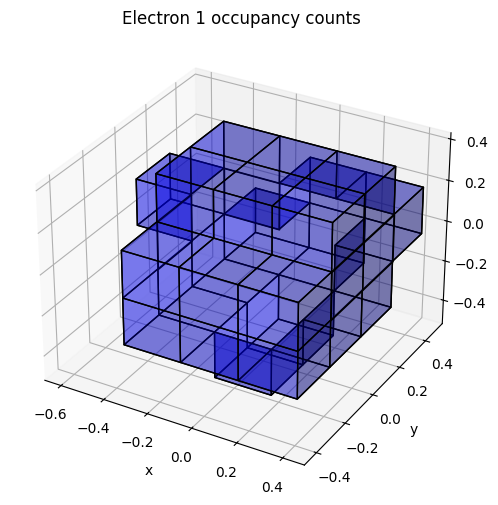

In [47]:
import numpy as np
import matplotlib.pyplot as plt

elec_idx = 0
coords = samples[:, 3*elec_idx:3*elec_idx+3]

bins = 30
hist, edges = np.histogramdd(coords, bins=bins, density=False)

xedges, yedges, zedges = edges
X, Y, Z = np.meshgrid(xedges, yedges, zedges, indexing='ij')

threshold = hist.max() * 0.3
mask = hist > threshold

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(X, Y, Z, mask, facecolors='blue', edgecolor='k', alpha=0.3)

ax.set_title(f"Electron {elec_idx+1} occupancy counts")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()


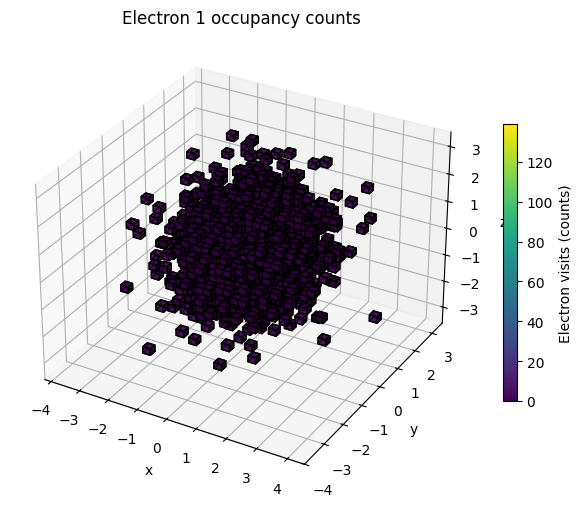

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

elec_idx = 0
coords = samples[:, 3*elec_idx:3*elec_idx+3]

# Histogram (raw counts)
bins = 30
hist, edges = np.histogramdd(coords, bins=bins, density=False)

xedges, yedges, zedges = edges
X, Y, Z = np.meshgrid(xedges, yedges, zedges, indexing='ij')

# Normalize counts to [0,1] for colormap
normed_hist = hist / hist.max()

# Mask: only plot voxels that were visited
mask = hist > 0

# Colormap: map counts to colors
colors = cm.viridis(normed_hist)  # shape (bins, bins, bins, 4)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.voxels(X, Y, Z, mask, facecolors=colors, edgecolor='k', alpha=0.7)

# Add colorbar (based on counts)
mappable = cm.ScalarMappable(cmap='viridis')
mappable.set_array(hist)
cbar = plt.colorbar(mappable, ax=ax, shrink=0.6)
cbar.set_label("Electron visits (counts)")

ax.set_title(f"Electron {elec_idx+1} occupancy counts")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()


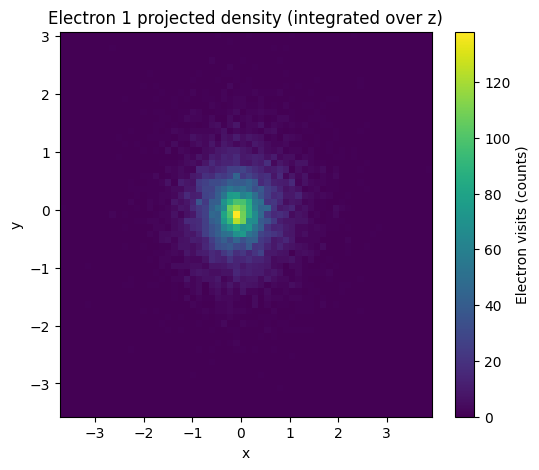

In [49]:
import numpy as np
import matplotlib.pyplot as plt

elec_idx = 0
coords = samples[:, 3*elec_idx:3*elec_idx+3]

# 3D histogram of counts
bins = 60
hist, edges = np.histogramdd(coords, bins=bins, density=False)

xedges, yedges, zedges = edges

# Project along z (sum over axis=2)
hist2d = hist.sum(axis=2)

fig, ax = plt.subplots(figsize=(6, 5))

X, Y = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
pcm = ax.pcolormesh(X, Y, hist2d, cmap='viridis')

fig.colorbar(pcm, ax=ax, label="Electron visits (counts)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title(f"Electron {elec_idx+1} projected density (integrated over z)")

plt.show()


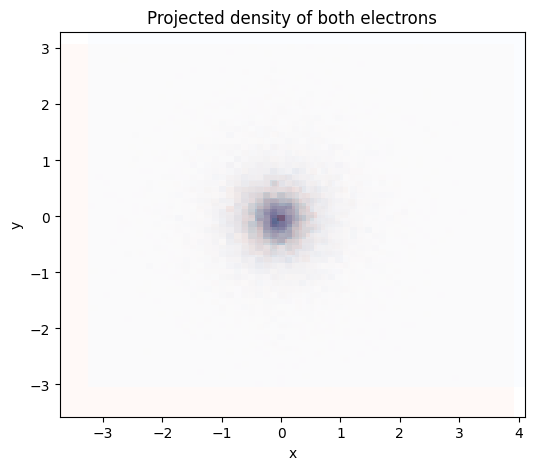

In [50]:
import numpy as np
import matplotlib.pyplot as plt

bins = 60
colors = ['Reds', 'Blues']  # different colormaps for each electron
fig, ax = plt.subplots(figsize=(6, 5))

for elec_idx, cmap in enumerate(colors):
    coords = samples[:, 3*elec_idx:3*elec_idx+3]
    hist, edges = np.histogramdd(coords, bins=bins, density=False)
    hist2d = hist.sum(axis=2)  # project along z
    
    X, Y = np.meshgrid(edges[0][:-1], edges[1][:-1], indexing='ij')
    pcm = ax.pcolormesh(X, Y, hist2d, cmap=cmap, alpha=0.5)
    
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Projected density of both electrons")
plt.show()


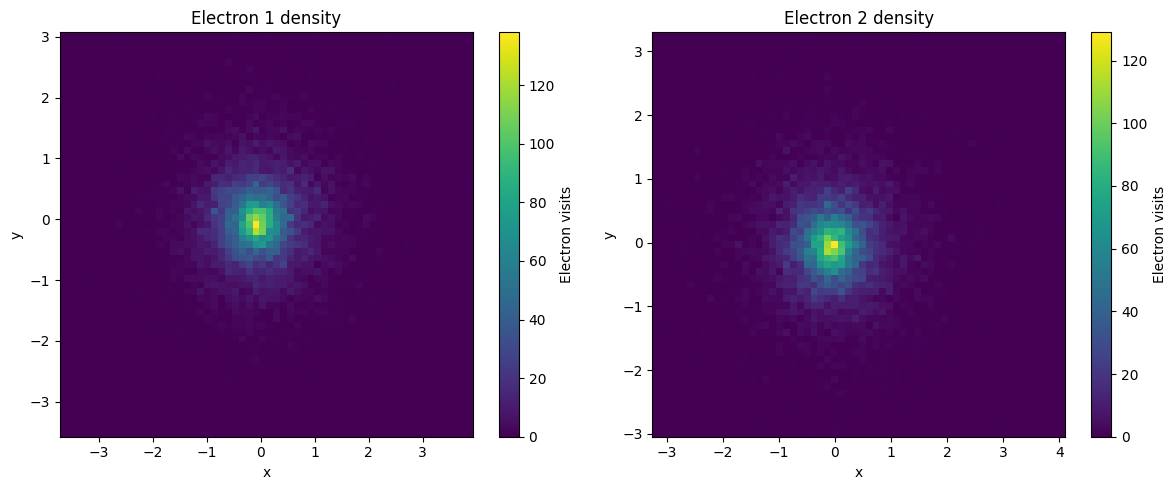

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for elec_idx, ax in enumerate(axes):
    coords = samples[:, 3*elec_idx:3*elec_idx+3]
    hist, edges = np.histogramdd(coords, bins=bins, density=False)
    hist2d = hist.sum(axis=2)  # project along z
    
    X, Y = np.meshgrid(edges[0][:-1], edges[1][:-1], indexing='ij')
    pcm = ax.pcolormesh(X, Y, hist2d, cmap='viridis')
    fig.colorbar(pcm, ax=ax, label="Electron visits")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Electron {elec_idx+1} density")

plt.tight_layout()
plt.show()


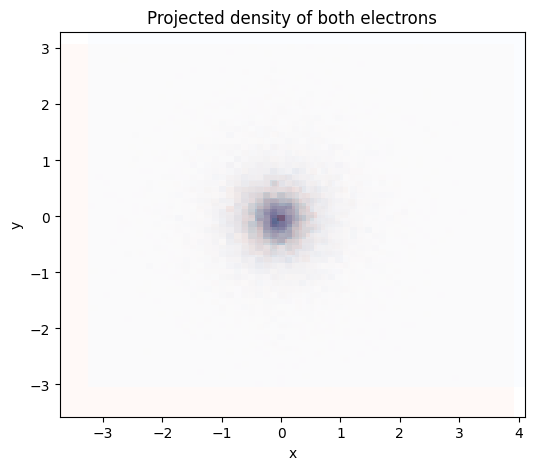

In [52]:
import numpy as np
import matplotlib.pyplot as plt

bins = 60
cmaps = ['Reds', 'Blues']  # one colormap per electron

fig, ax = plt.subplots(figsize=(6, 5))

for elec_idx, cmap in enumerate(cmaps):
    coords = samples[:, 3*elec_idx:3*elec_idx+3]
    
    # 3D histogram, then project to 2D (sum along z)
    hist, edges = np.histogramdd(coords, bins=bins, density=False)
    hist2d = hist.sum(axis=2)
    
    X, Y = np.meshgrid(edges[0][:-1], edges[1][:-1], indexing='ij')
    ax.pcolormesh(X, Y, hist2d, cmap=cmap, alpha=0.5, shading='auto')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Projected density of both electrons")
plt.show()
